In [203]:
%matplotlib inline

# Imports
import pandas
import numpy as np 
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from scipy.misc import *
from scipy.sparse import *
import itertools

## Data

In [4]:
# http://www.gbif.org/occurrence/search?TAXON_KEY=359&YEAR=2014#
# This is data for all Mammals in 2014 across the whole planet
mammals = pandas.read_csv('Data/Mammalia_2014.csv', sep='\t')

In [33]:
# Create a subset data frame that just contains the columns that we need
species_lat_longs = mammals[['species','decimallatitude','decimallongitude']]

# Drop all NaNs
species_lat_longs = species_lat_longs.dropna()

# Examine the head of the data frame
species_lat_longs.head()

,species,decimallatitude,decimallongitude
1,Papio anubis,10.9333,1.1166
3,Vulpes pallida,10.9333,1.1166
4,Crocuta crocuta,12.0000,2.5833
5,Aonyx capensis,6.4833,2.5333
6,Papio anubis,9.0166,1.6666


In [119]:
species_array = species_lat_longs.species.unique()
print "Found %d unique species in the dataset" % len(species_array)

Found 1068 unique species in the dataset


In [196]:
# Create a species dictionary for quick conversion of species name to id
species_dictionary = {}
species_lookup_dict = {}
for i, s in enumerate(species_array):
    species_dictionary[s] = i
    species_lookup_dict[i] = s

In [207]:
# Create the 10.0 x 10.0 lat-long grid squares
# Changing the size of the lat-long grid squares will have a large effect on the results
lats = np.arange(-90, 100, 5)
longs = np.arange(-180, 190, 5)

In [208]:
# Generate the grid
grids = list(itertools.product(lats, longs))

In [209]:
num_grids = len(grids)
print "Using these lat-long settings, there are %d grid squares" % num_grids

Using these lat-long settings, there are 2812 grid squares


In [210]:
# Generate the grid indexes
lat_ids = np.digitize(lats, lats)
long_ids = np.digitize(longs, longs)

grid_ids = list(itertools.product(lat_ids, long_ids))

In [211]:
def get_grid_id_from_lat_long(a_lat, a_long):
    a_lat_id = np.digitize(a_lat, lats).item(0)
    a_long_id = np.digitize(a_long, longs).item(0)
    return grid_ids.index((a_lat_id, a_long_id))

In [212]:
grid_counts = np.zeros(len(grid_ids))
species_counts = np.zeros(len(species_array))

grid_species_count_dict = {}

# Build up the grid species count dictionary
for i in range(0, len(species_lat_longs)):
    # Get the species id
    species_id = species_dictionary[species_lat_longs.iloc[i,0]]
    # Get the grid id
    grid_id = get_grid_id_from_lat_long(species_lat_longs.iloc[i,1], species_lat_longs.iloc[i,2])

    # Add one to the number of observations in this grid square
    grid_counts[grid_id] += 1
    # Add one to the number of observations of this species
    species_counts[species_id] += 1
    
    if grid_id not in grid_species_count_dict:
        grid_species_count_dict[grid_id] = {}
    if species_id not in grid_species_count_dict[grid_id]:
        grid_species_count_dict[grid_id][species_id] = 0
    
    grid_species_count_dict[grid_id][species_id] += 1

In [213]:
# Convert the grid species count dictionary to an array of arrays

# We want this to be in the following format:
#    [[    1  4720     1], [    1  9775     4], [    1 19996     1]...]
# Where each entry is an array of three elements, the first corresponding to the grid square id, 
# the second corresponding to the species id, and the third to the number of times that species
# was observed in this particular grid square
grid_species_counts = []

for grid_id in grid_species_count_dict.keys():
    for species_id in grid_species_count_dict[grid_id].keys():
        grid_species_counts.append([grid_id, species_id, grid_species_count_dict[grid_id][species_id]])

# EM

In [220]:
class LDA(object):

    # Initializes with the number of topics
    def __init__(self, species_lookup_dict, data, num_topics):
        self.num_topics = num_topics
        self.species_lookup_dict = species_lookup_dict
        self.num_species = len(species_lookup_dict)
        
        counts = np.reshape(data[:,2], len(data)).tolist()[0]
        doc_ids = np.reshape(data[:,0], len(data)).tolist()[0]
        species_ids = np.reshape(data[:,1], len(data)).tolist()[0]
                             
        # Setup the word count matrix to keep track of which words appeared in a particular document
        W = csr_matrix((counts,(doc_ids, species_ids)),shape=(num_grids, self.num_species))

        # Store the total number of observations in each grid square
        N = csr_matrix.sum(W, axis=1).reshape([num_grids,1])
            
        self.W = W
        self.N = N

        # Run EM
        self.run_EM()

    def run_EM(self):
        # Initialize our beliefs for theta and beta

        # Theta will be generated from a uniform initial distribution
        theta = np.random.rand(self.num_topics)
        # Normalize theta
        theta = theta / np.sum(theta)
        theta = theta.reshape([self.num_topics, 1])

        # Beta will be generated from a uniform normalized by column (species)
        beta = np.random.rand(self.num_topics, self.num_species)
        # Normalize Beta
        beta_row_sums = beta.sum(axis=1)
        beta = beta / beta_row_sums[:, np.newaxis]
        beta = beta
        self.lls = []
        
        self.smoothing = .0000001
        
        i = 0
        # While the algorithm hasn't converged, run EM
        while True:
            print "Iteration %d" % i
            i += 1
            
            # Run the E and M steps
            Q = self.E_step(beta, theta)
            beta, theta = self.M_step(Q)
            
            # Calculate the log-likelihood
            ll = np.multiply(Q, np.add(np.log(theta.T+self.smoothing), self.W.dot(np.log(beta.T+self.smoothing))).T)
            ll = np.sum(ll)
            self.lls.append(ll)
            #print "Log Likelihood", ll
            self.Q = Q
            self.beta = beta
            self.theta = theta
            
            if i > 1:
                if np.abs(self.lls[-1] - self.lls[-2]) < .1:
                    print "Converged!"
                    break

        # Print the topics for this iteration
        self.print_topics(10, beta, theta)
                    
        self.plot_ll()

    # This should run the E step of the EM algorithm
    def E_step(self, beta, theta):
        # Create the new expectation matrix Q (grid squares by topic probabilities)
        Q = np.add(np.log(theta.T+self.smoothing), self.W.dot(np.log(beta.T+self.smoothing))).T
        Q = np.subtract(Q, logsumexp(Q, axis=0))
        # Exponentiate to move back to regular space
        Q = np.exp(Q)
        return Q
        
    # This should run the M step of the EM algorithm
    def M_step(self, Q):
        # Maximize Theta
        theta = np.mean(Q, axis=1)
        theta = theta.reshape([self.num_topics, 1])
        self.theta = theta
        
        # Maximize Beta
        beta = (self.W.T.dot(Q.T)).T/np.dot(Q, self.N)
        self.beta = beta
        return beta, theta

    # This should print the top species per topic
    def print_topics(self, num_species, beta, theta):
        print "Top Species Per Topic"
        for k in range(self.num_topics):
            a = np.array(beta[k])[0]
            ind = np.argsort(a)[-num_species:]
            species = []
            for an_ind in ind:
                species.append(self.species_lookup_dict[an_ind])
            print "Topic ", k, " species: ", species
            
    def plot_ll(self):
        plt.plot(range(len(self.lls)), self.lls)
        plt.title("Log Likelihood per Iteration with %d topics" % self.num_topics)
        plt.xlabel("EM Iteration")
        plt.ylabel("Log Likelihood")
        #plt.savefig('ll_%d_topics.png' % self.num_topics)
        plt.show()

Iteration 0
Iteration 1
Iteration 2
Iteration 3
Iteration 4
Iteration 5
Iteration 6
Iteration 7
Iteration 8
Iteration 9
Iteration 10
Iteration 11
Iteration 12
Iteration 13
Iteration 14
Iteration 15
Iteration 16
Iteration 17
Iteration 18
Iteration 19
Iteration 20
Iteration 21
Iteration 22
Iteration 23
Iteration 24
Iteration 25
Iteration 26
Iteration 27
Iteration 28
Iteration 29
Iteration 30
Iteration 31
Iteration 32
Iteration 33
Iteration 34
Iteration 35
Iteration 36
Iteration 37
Iteration 38
Iteration 39
Iteration 40
Iteration 41
Iteration 42
Iteration 43
Iteration 44
Iteration 45
Iteration 46
Iteration 47
Iteration 48
Iteration 49
Iteration 50
Iteration 51
Iteration 52
Iteration 53
Iteration 54
Iteration 55
Iteration 56
Iteration 57
Iteration 58
Iteration 59
Iteration 60
Iteration 61
Iteration 62
Iteration 63
Iteration 64
Iteration 65
Iteration 66
Iteration 67
Iteration 68
Iteration 69
Converged!
Top Species Per Topic
Topic  0  species:  ['Felis catus', 'Vulpes vulpes', 'Alces alces',

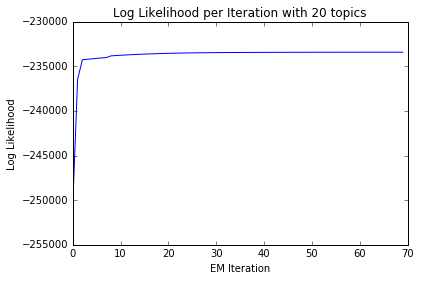

In [221]:
LDAClassifier = LDA(species_lookup_dict=species_lookup_dict, data=np.matrix(grid_species_counts), num_topics=20)

# Results